In [1]:
# path to sequence_vaes directory
# abspath = "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
abspath = ".."

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json
from treetime.utils import datetime_from_numeric
from collections.abc import Iterable
import matplotlib.cm as cm

# path to sequence_vaes directory and pip install
# %cd "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
# !pip install -r requirements.txt

In [3]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import bedford_code.models_bedford as bedford
import utils

from sklearn_extra.cluster import KMedoids
from scipy.optimize import minimize
from scipy.optimize._numdiff import approx_derivative

In [4]:
BATCH_SIZE = 64

# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [6]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50, non_linear_activation=nn.Softplus(beta=1.0)).to(DEVICE)
vae_model.load_state_dict(torch.load("./model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))


vae_model.eval()

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


VAE(
  (non_linear_activation): Softplus(beta=1.0, threshold=20)
  (encoder): Encoder(
    (non_linear_activation): Softplus(beta=1.0, threshold=20)
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): Softplus(beta=1.0, threshold=20)
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): Softplus(beta=1.0, threshold=20)
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): Softplus(beta=1.0, threshold=20)
    (decode): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Softplus(beta=1.0, threshold=20)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): Softplus(beta=1.0, threshold=20)
      (4): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [7]:
import utils
dset = ["training", "valid", "test"]
dset = dset[0]
abspath = ".."


# LOAD DATA
data_keys, data_dict = utils.get_data_dict(dset, abspath)
print(data_keys)
new_dataset = data_dict["new_dataset"]
vals = data_dict["vals"]
metadata = data_dict["metadata"]
clade_labels = data_dict["clade_labels"]
collection_dates = data_dict["collection_dates"]
indexes = data_dict["indexes"]
pairs = data_dict["pairs"]
get_parents_dict = data_dict["get_parents_dict"]


collection_dates
 [21, 54, 67, 86, 108, 140, 154, 187, 206, 220, 240, 257, 264, 275, 282, 288, 291, 308, 333, 345, 358, 369, 377, 386, 397, 408, 416, 426, 435, 461, 798, 1373, 2807, 4105, 5241, 6264, 6368]

unique clusters
 ['19A' '21K (BA.1)' '21L (BA.2)' '21M (Omicron)' '22A (BA.4)' '22B (BA.5)'
 '22C (BA.2.12.1)' '22D (BA.2.75)' '22E (BQ.1)' '22F (XBB)'
 '23A (XBB.1.5)' '23B (XBB.1.16)' '23C (CH.1.1)' '23D (XBB.1.9)'
 '23E (XBB.2.3)' '23F (EG.5.1)' '23G (XBB.1.5.70)' '23H (HK.3)'
 '23I (BA.2.86)' '24A (JN.1)' '24D (XDV.1)' '24E (KP.3.1.1)' '24F (XEC)'
 '24G (KP.2.3)' '24H (LF.7)' '24I (MV.1)' '25A (LP.8.1)' '25B (NB.1.8.1)'
 '25C (XFG)']

sanity check - len(new_vals), len(vals)
 6368   6368
['new_dataset', 'vals', 'metadata', 'clade_labels', 'collection_dates', 'indexes', 'pairs', 'get_parents_dict']


In [8]:
vae_model = vae_model.requires_grad_(False)
Z_mean, Z_logvar, recon, genome, genome_recon = utils.model_eval(vae_model, new_dataset, model_type="STANDARD")
Z_mean = torch.tensor(Z_mean).to(DEVICE).float()
_, uniq_indices, uniq_inverse = np.unique(genome, axis=0, return_index=True, return_inverse=True)


Recon shape
torch.Size([6368, 19110])


In [9]:
print(vae_model.decoder)

Decoder(
  (non_linear_activation): Softplus(beta=1.0, threshold=20)
  (decode): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): Softplus(beta=1.0, threshold=20)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): Softplus(beta=1.0, threshold=20)
    (4): Linear(in_features=512, out_features=19110, bias=True)
  )
)


In [10]:
# compute riemannian metric at different points
def get_riemannian_metric(X):

    # jacrev combined with vmap for very fast batched jacobian compuation 
    # Jac has dimensions (b, x_dim, z_dim)
    jac = torch.func.vmap(torch.func.jacrev(vae_model.decoder.decode))(X)
    # batched Jac^T * Jac
    # metric has dimensions (b, z_dim, z_dim)
    manifold_metric = torch.einsum("bij,bjk->bik", torch.permute(jac, (0, 2, 1)), jac)
        
    # print(metric.shape)

    return manifold_metric

def get_metrics(X):
    
    print(X.shape)
    batch_len = 50

    n_reps = X.shape[0] // batch_len
    if batch_len * n_reps < X.shape[0]:
        n_reps += 1
    
    batches = []
    for i in range(n_reps):
        s = i * batch_len
        e = s + batch_len
    
        batch = X[s:e]
        
        batches.append(get_riemannian_metric(batch))

    return batches

def get_det_metric(metric):
    return 0.5 * torch.log(torch.linalg.det(torch.cat(metric, dim=0)) + 1e-10).cpu().numpy()

In [11]:
Z_mean_np = Z_mean.cpu().numpy()

pca = PCA(n_components=4, svd_solver="full")
pca.fit(Z_mean_np - np.mean(Z_mean_np))
variances = pca.explained_variance_ratio_
tot = np.sum(variances)

print(variances, "\n")
print(f"total variance: {tot}")

[0.40960428 0.28285992 0.21266271 0.07270278] 

total variance: 0.9778296947479248


In [12]:
N_components = 2
pca = PCA(n_components=N_components, svd_solver="full")
pca.fit(Z_mean_np - np.mean(Z_mean_np))
Z_embedded = pca.transform(Z_mean_np - np.mean(Z_mean_np))

xmax, ymax = np.max(Z_embedded, axis=0) + 0.5
xmin, ymin = np.min(Z_embedded, axis=0) - 0.5

In [13]:
Z_mean_recon = pca.inverse_transform(Z_embedded)

In [14]:
print(Z_mean_recon.shape)
print(Z_mean_np.shape)

print(np.sum(np.abs((Z_mean_recon + np.mean(Z_mean_np))  - Z_mean_np)) / (Z_mean_np.shape[0] * Z_mean_np.shape[0]))

(6368, 50)
(6368, 50)
0.0005203588650487342


In [28]:
N = 100
X,Y = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))

space = np.concatenate((X.ravel()[:, None], Y.ravel()[:, None]), axis=-1)
space_recon = pca.inverse_transform(space) + np.mean(Z_mean_np)

In [ ]:
space_recon_metrics = get_det_metric(get_metrics(torch.tensor(space_recon).to(DEVICE).float())).reshape(X.shape)

In [ ]:
z_metrics = get_det_metric(get_metrics(Z_mean[uniq_indices]))

In [ ]:
print(z_metrics.shape)

In [ ]:
fig,arr = plt.subplots(1,1,figsize=(14,14))

vmin = np.min([np.min(z_metrics), np.min(space_recon_metrics)])
vmax = np.max([np.max(z_metrics), np.max(space_recon_metrics)])

# scatterplot = plt.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], c=z_metrics, cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
arr.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], color="black", alpha=0.5)
display = plt.imshow(space_recon_metrics, interpolation='gaussian', origin='lower',
               extent=(xmin, xmax, ymin, ymax),
               cmap=cm.RdBu_r, aspect='equal', vmin=vmin, vmax=vmax)
plt.colorbar(display,  shrink=0.5)

plt.xticks([])
plt.yticks([])
plt.xlabel("pca 0, %.3f"%(variances[0]), fontsize=20)
plt.ylabel("pca 1, %.3f"%(variances[1]), fontsize=20)

plt.show()

In [16]:
c = 250
kmedoids = KMedoids(n_clusters=c, random_state=1, init="k-medoids++").fit(Z_mean[uniq_indices, :].cpu().numpy())
kmed_index = [uniq_indices[x] for x in kmedoids.medoid_indices_]
Z_var = torch.tensor(np.exp(Z_logvar)).to(DEVICE)

mu = Z_mean[kmed_index,:]
sigma = Z_var[kmed_index,:]

rho = utils.compute_rho(mu)

In [29]:
space_recon_metrics_chadebec = utils.G_batched(torch.tensor(space_recon).to(DEVICE).float(), mu, sigma, rho, lam=0.8).cpu().numpy()
space_recon_metrics_chadebec = 0.5 * np.sum(np.log(space_recon_metrics_chadebec), axis=-1).reshape(X.shape)

z_metrics_chadebec = utils.G_batched(Z_mean[uniq_indices,:], mu, sigma, rho, lam=1).cpu().numpy()
z_metrics_chadebec = 0.5 * np.sum(np.log(z_metrics_chadebec), axis=-1)

print(space_recon_metrics_chadebec.shape)
print(z_metrics_chadebec.shape)

(100, 100)
(1593,)


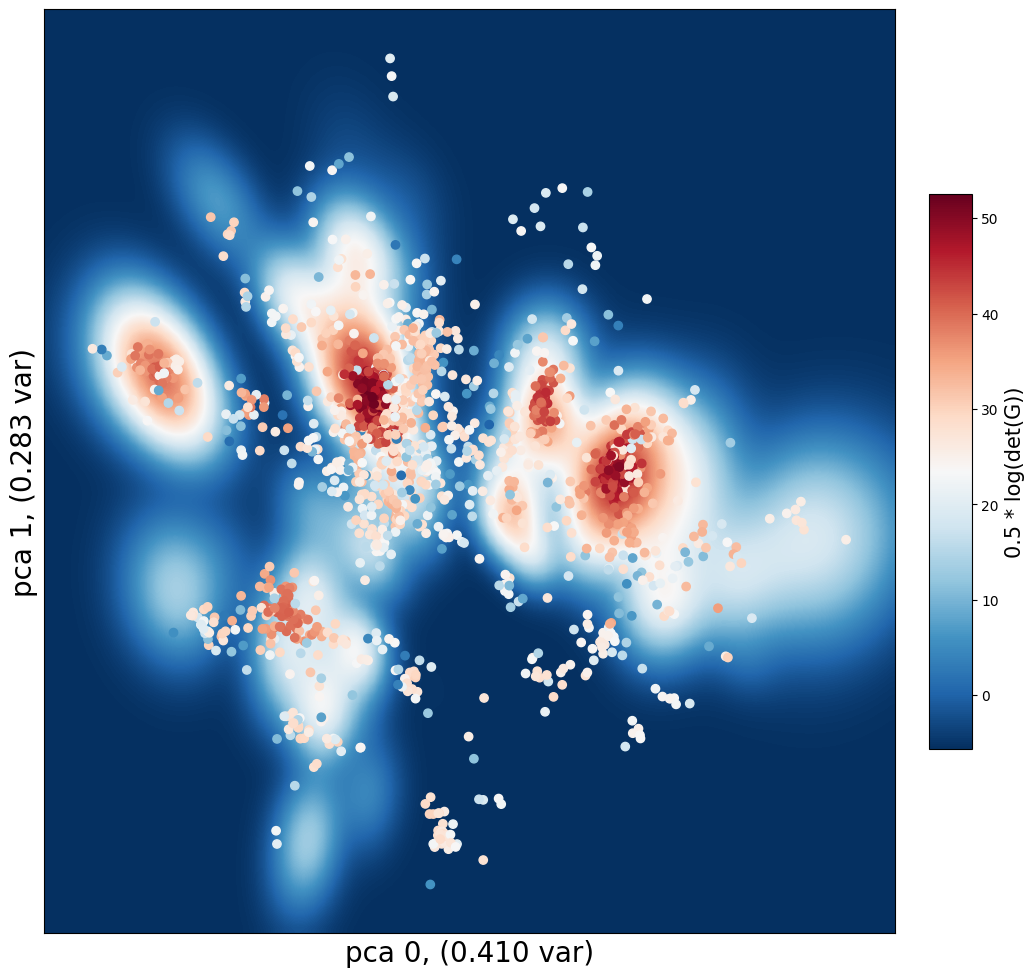

In [30]:
fig,arr = plt.subplots(1,1,figsize=(12,12))

vmin = np.min([np.min(z_metrics_chadebec), np.min(space_recon_metrics_chadebec)])
vmax = np.max([np.max(z_metrics_chadebec), np.max(space_recon_metrics_chadebec)])

arr.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], c=z_metrics_chadebec, cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
# arr.scatter(Z_embedded[uniq_indices,0], Z_embedded[uniq_indices,1], color="black", alpha=0.5)
display = arr.imshow(space_recon_metrics_chadebec, interpolation='gaussian', origin='lower',
               extent=(xmin, xmax, ymin, ymax),
               cmap=cm.RdBu_r, aspect='equal', vmin=vmin, vmax=vmax)

plt.xticks([])
plt.yticks([])
plt.xlabel("pca 0, (%.3f var)"%(variances[0]), fontsize=20)
plt.ylabel("pca 1, (%.3f var)"%(variances[1]), fontsize=20)

cax = arr.inset_axes([1.04, 0.2, 0.05, 0.6])
cbar = plt.colorbar(display, cax=cax, shrink=0.25)
cbar.set_label('0.5 * log(det(G))', fontsize=15)


plt.show()